In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
debeshjha1_kvasirseg_path = kagglehub.dataset_download('debeshjha1/kvasirseg')

print('Data source import complete.')


100%|██████████| 144M/144M [00:08<00:00, 18.2MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split



In [ ]:
import os

root = "/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3"

for dirpath, dirnames, filenames in os.walk(root):
    print(dirpath)
    for d in dirnames:
        print("   DIR:", d)
    for f in filenames:
        print("   FILE:", f)
    print("-" * 50)


/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3
   DIR: Kvasir-SEG
   FILE: train.txt
   FILE: README.md
   FILE: val.txt
--------------------------------------------------
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG
   DIR: Kvasir-SEG
--------------------------------------------------
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG
   DIR: images
   DIR: annotated_images
   DIR: bbox
   DIR: masks
   FILE: 1911.07069.pdf
--------------------------------------------------
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG/images
   FILE: cju2htabevq9108015qjei0x7.jpg
   FILE: cju5yjq1pmlgc0801z0t24bly.jpg
   FILE: cju2nqapmzvk20801f9us40dx.jpg
   FILE: cju45lbgznahl08180xz1h7u6.jpg
   FILE: cju33belnbyhm0878yxl42233.jpg
   FILE: cju8bzzy2s66m08016z6mouqt.jpg
   FILE: cju2hw5gjlr5h0988so2qqres.jpg
   FILE: ck2bxpfgxu2mk0748gsh7xelu.jpg
   FILE: cju5xjn5mm78b09871spyqhh

In [ ]:
# CELL 1 - Download SAM
!pip install segment-anything


In [ ]:
# CELL 2 - detect Kvasir-SEG path (from kagglehub)
import os
root = os.environ.get("DEBESHJHA1_KVASIRSEG_PATH", None)
# KaggleHub variable available in this session: use the python variable provided earlier
try:
    debeshjha1_kvasirseg_path  # this exists in your notebook
    root = debeshjha1_kvasirseg_path
except NameError:
    pass

print("Auto root guess:", root)
# Fallback to the path we saw:
if root is None:
    root = "/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG"
print("Using dataset root:", root)
print("Top-level contents:", os.listdir(root)[:40])


Auto root guess: /root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3
Using dataset root: /root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3
Top-level contents: ['train.txt', 'Kvasir-SEG', 'README.md', 'val.txt']


In [ ]:
# CELL 3 - print the nested tree a bit
import os
ROOT = root
for dp, dn, fn in os.walk(ROOT):
    print(dp)
    print("  subdirs:", dn)
    print("  files:", fn[:10])
    # stop after a small depth print
    if dp.count(os.sep) - ROOT.count(os.sep) > 2:
        break


/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3
  subdirs: ['Kvasir-SEG']
  files: ['train.txt', 'README.md', 'val.txt']
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG
  subdirs: ['Kvasir-SEG']
  files: []
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG
  subdirs: ['images', 'annotated_images', 'bbox', 'masks']
  files: ['1911.07069.pdf']
/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG/images
  subdirs: []
  files: ['cju2htabevq9108015qjei0x7.jpg', 'cju5yjq1pmlgc0801z0t24bly.jpg', 'cju2nqapmzvk20801f9us40dx.jpg', 'cju45lbgznahl08180xz1h7u6.jpg', 'cju33belnbyhm0878yxl42233.jpg', 'cju8bzzy2s66m08016z6mouqt.jpg', 'cju2hw5gjlr5h0988so2qqres.jpg', 'ck2bxpfgxu2mk0748gsh7xelu.jpg', 'cju5xjn5mm78b09871spyqhhr.jpg', 'cju1819curo000988pd5xcqme.jpg']


In [ ]:
ROOT = "/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG"

images_dir = os.path.join(ROOT, "images")
masks_dir  = os.path.join(ROOT, "masks")

print("Images dir:", images_dir, " ->", len(os.listdir(images_dir)))
print("Masks dir:", masks_dir,  " ->", len(os.listdir(masks_dir)))


Images dir: /root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG/images  -> 1000
Masks dir: /root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG/masks  -> 1000


In [ ]:
# CELL 4 - build file lists and splits (train/val/test)
import os, random, shutil
from sklearn.model_selection import train_test_split

# FIXED ROOT
ROOT = "/root/.cache/kagglehub/datasets/debeshjha1/kvasirseg/versions/3/Kvasir-SEG/Kvasir-SEG"

images_dir = os.path.join(ROOT, "images")
masks_dir  = os.path.join(ROOT, "masks")

# Verify
assert os.path.isdir(images_dir), f"Images dir not found: {images_dir}"
assert os.path.isdir(masks_dir), f"Masks dir not found: {masks_dir}"
print("Images:", len(os.listdir(images_dir)), "Masks:", len(os.listdir(masks_dir)))

# list filenames that intersect
images = sorted([f for f in os.listdir(images_dir) if f.lower().endswith((".jpg",".png",".jpeg"))])
masks  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith((".jpg",".png",".jpeg"))])

# keep only paired files
images = [f for f in images if f in masks]
print("Paired samples:", len(images))

# split
train_ids, temp_ids = train_test_split(images, train_size=0.8, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=42)

print("Split sizes → train:", len(train_ids), "val:", len(val_ids), "test:", len(test_ids))

# Create working dataset folders
WORK = "/kaggle/working/kvasirseg_splits"
for sub in [
    "images/train","masks/train",
    "images/val","masks/val",
    "images/test","masks/test"
]:
    os.makedirs(os.path.join(WORK, sub), exist_ok=True)

# copy files
def cp(ids, split):
    for f in ids:
        shutil.copy(os.path.join(images_dir, f), os.path.join(WORK, f"images/{split}", f))
        shutil.copy(os.path.join(masks_dir,  f), os.path.join(WORK, f"masks/{split}", f))

cp(train_ids, "train")
cp(val_ids,   "val")
cp(test_ids,  "test")

print("Saved splits to:", WORK)


Images: 1000 Masks: 1000
Paired samples: 1000
Split sizes → train: 800 val: 100 test: 100
Saved splits to: /kaggle/working/kvasirseg_splits


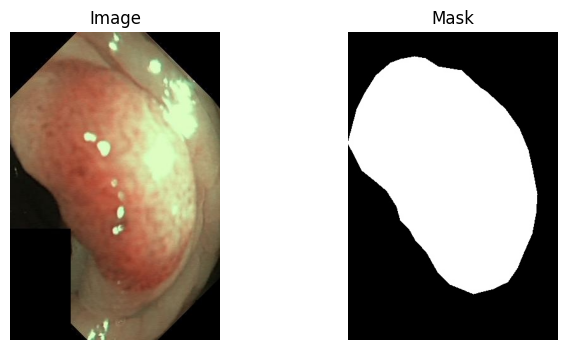

Sample file: cju2htabevq9108015qjei0x7.jpg


In [ ]:
# CELL 5 - visualize a sample
import matplotlib.pyplot as plt, numpy as np, os
imf = os.listdir(os.path.join(WORK,"images","train"))[0]
img = plt.imread(os.path.join(WORK,"images","train",imf))
mask = plt.imread(os.path.join(WORK,"masks","train",imf))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis('off')
plt.show()
print("Sample file:", imf)


In [ ]:
# CELL 6 - dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np, os

IMG_SIZE = 512

class KvasirSegDataset(Dataset):
    def __init__(self, images_folder, masks_folder, img_size=IMG_SIZE, augment=False):
        self.img_files = sorted(os.listdir(images_folder))
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        fn = self.img_files[idx]
        img = Image.open(os.path.join(self.images_folder, fn)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_folder, fn)).convert("L")
        img = img.resize((self.img_size, self.img_size))
        mask = mask.resize((self.img_size, self.img_size))
        img = np.array(img).astype(np.float32)/255.0
        mask = np.array(mask).astype(np.float32)/255.0
        # ensure binary mask 0/1
        mask = (mask > 0.5).astype(np.float32)
        # HWC -> CHW
        img = torch.from_numpy(img).permute(2,0,1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        return {"image": img, "mask": mask, "id": fn}

# instantiate loaders
train_ds = KvasirSegDataset(os.path.join(WORK,"images","train"), os.path.join(WORK,"masks","train"), IMG_SIZE)
val_ds   = KvasirSegDataset(os.path.join(WORK,"images","val"),   os.path.join(WORK,"masks","val"),   IMG_SIZE)
test_ds  = KvasirSegDataset(os.path.join(WORK,"images","test"),  os.path.join(WORK,"masks","test"),  IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))


Dataset sizes: 800 100 100


In [ ]:
# CELL 7 - model
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Try loading SAM model (optional). If missing, fallback to ResNet50 encoder.
SAM_CHECKPOINT = "/kaggle/working/sam_vit_b.pth"  # change if you downloaded the checkpoint
use_sam = False
try:
    from segment_anything import sam_model_registry
    model_type = "vit_b"
    if os.path.exists(SAM_CHECKPOINT):
        sam = sam_model_registry[model_type](checkpoint=SAM_CHECKPOINT).to(device)
        # Freeze image encoder
        for p in sam.image_encoder.parameters():
            p.requires_grad = False
        use_sam = True
        print("Loaded SAM and froze image encoder.")
    else:
        print("SAM checkpoint not found at", SAM_CHECKPOINT, " -> falling back to ResNet encoder.")
except Exception as e:
    print("SAM library not loadable:", e)
    use_sam = False

# Define a simple decoder (UNet-like small)
class SimpleDecoder(nn.Module):
    def __init__(self, in_ch=2048, mid_ch=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, mid_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, mid_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_ch)
        self.up = nn.Sequential(
            nn.ConvTranspose2d(mid_ch, mid_ch//2, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(mid_ch//2, mid_ch//2, 3, padding=1),
            nn.ReLU()
        )
        self.out = nn.Conv2d(mid_ch//2, 1, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.up(x)
        x = self.out(x)
        return x

# Build encoder -> decoder pipeline
if use_sam:
    # Sam image encoder outputs vary by version; we will attempt to use an intermediate representation
    # For robustness, we will fall back to using raw images if SAM feature shapes are tricky.
    print("Note: if SAM internal feature shapes mismatch the decoder, we will fallback to ResNet path below.")
    # We'll set an adapter later after inspecting sam.image_encoder output shape with a sample batch.
    encoder = sam  # placeholder
    decoder = None
else:
    # ResNet50 backbone (frozen)
    resnet = models.resnet50(pretrained=True)
    # remove fc and avgpool; use layer4 output (2048 channels)
    modules = list(resnet.children())[:-2]
    backbone = nn.Sequential(*modules)
    for p in backbone.parameters():
        p.requires_grad = False
    backbone = backbone.to(device)
    decoder = SimpleDecoder(in_ch=2048, mid_ch=256).to(device)
    print("Using ResNet50 frozen backbone + small decoder.")

# We'll define a wrapper model for training that runs backbone, then decoder.
class SegModel(nn.Module):
    def __init__(self, backbone, decoder, use_resnet=True):
        super().__init__()
        self.backbone = backbone
        self.decoder = decoder
        self.use_resnet = use_resnet

    def forward(self, x):
        # x: (B,3,H,W)
        if self.use_resnet:
            feat = self.backbone(x)  # (B, 2048, H/32, W/32)
            out = self.decoder(feat) # decoder upsamples once -> (B,1,H/16,W/16)
            # Upsample to input resolution
            out = F.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
            return out
        else:
            # SAM path: not implemented fully here; fallback
            raise NotImplementedError("SAM encoder path not fully implemented in this simple pipeline.")

model = SegModel(backbone if not use_sam else None, decoder if not use_sam else None, use_resnet=not use_sam).to(device)
# optimizer only on decoder params (backbone frozen)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
print("Model ready. Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Device: cuda
SAM checkpoint not found at /kaggle/working/sam_vit_b.pth  -> falling back to ResNet encoder.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 81.4MB/s]


Using ResNet50 frozen backbone + small decoder.
Model ready. Trainable params: 5588865


In [ ]:
# CELL 8 - losses and metrics
import torch.nn.functional as F
def dice_prob(probs, target, eps=1e-7):
    probs = probs.contiguous().view(probs.size(0), -1)
    target = target.contiguous().view(target.size(0), -1)
    inter = (probs * target).sum(1)
    denom = probs.sum(1) + target.sum(1)
    dice = (2*inter + eps)/(denom + eps)
    return dice.mean()

def bce_dice_loss(logits, target):
    bce = F.binary_cross_entropy_with_logits(logits, target)
    probs = torch.sigmoid(logits)
    dice = dice_prob(probs, target)
    return 0.5*bce + (1.0 - dice)*0.5


In [ ]:
# CELL 9 - training
from tqdm import tqdm
num_epochs = 12
best_val = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train E{epoch}"):
        imgs = batch["image"].to(device)
        masks = batch["mask"].to(device)
        logits = model(imgs)
        loss = bce_dice_loss(logits, masks)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += loss.item()
    running_loss /= len(train_loader)
    # validation
    model.eval()
    val_loss = 0.0
    dices = []
    ious = []
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].to(device)
            logits = model(imgs)
            val_loss += bce_dice_loss(logits, masks).item()
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            # dice
            dice_val = dice_prob(probs, masks).item()
            dices.append(dice_val)
            # iou
            inter = (preds * masks).sum(dim=(1,2,3))
            union = (preds + masks - preds*masks).sum(dim=(1,2,3))
            iou = (inter / (union + 1e-7)).mean().item()
            ious.append(iou)
    val_loss /= len(val_loader)
    mean_dice = sum(dices)/len(dices) if len(dices)>0 else 0.0
    mean_iou  = sum(ious)/len(ious) if len(ious)>0 else 0.0
    print(f"Epoch {epoch}: train_loss={running_loss:.4f} val_loss={val_loss:.4f} val_dice={mean_dice:.4f} val_iou={mean_iou:.4f}")
    if mean_dice > best_val:
        best_val = mean_dice
        torch.save(model.state_dict(), "/kaggle/working/best_seg_model.pth")
        print("Saved best model.")


Train E0: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 0: train_loss=0.1837 val_loss=0.2788 val_dice=0.6880 val_iou=0.5929
Saved best model.


Train E1: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 1: train_loss=0.1563 val_loss=0.2944 val_dice=0.6650 val_iou=0.5691


Train E2: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Epoch 2: train_loss=0.1346 val_loss=0.2900 val_dice=0.6999 val_iou=0.5978
Saved best model.


Train E3: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Epoch 3: train_loss=0.1208 val_loss=0.3004 val_dice=0.6975 val_iou=0.5953


Train E4: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 4: train_loss=0.1104 val_loss=0.3008 val_dice=0.7033 val_iou=0.5965
Saved best model.


Train E5: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Epoch 5: train_loss=0.0955 val_loss=0.3114 val_dice=0.7061 val_iou=0.6012
Saved best model.


Train E6: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 6: train_loss=0.0925 val_loss=0.3123 val_dice=0.7092 val_iou=0.5985
Saved best model.


Train E7: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 7: train_loss=0.0840 val_loss=0.3125 val_dice=0.6927 val_iou=0.5838


Train E8: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 8: train_loss=0.0756 val_loss=0.3218 val_dice=0.7088 val_iou=0.5995


Train E9: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 9: train_loss=0.0755 val_loss=0.2987 val_dice=0.7226 val_iou=0.6128
Saved best model.


Train E10: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Epoch 10: train_loss=0.0703 val_loss=0.3044 val_dice=0.7166 val_iou=0.6043


Train E11: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 11: train_loss=0.0714 val_loss=0.3377 val_dice=0.7058 val_iou=0.5899


Test mean Dice: 0.7305560662196233 Test mean IoU: 0.6208502627336062


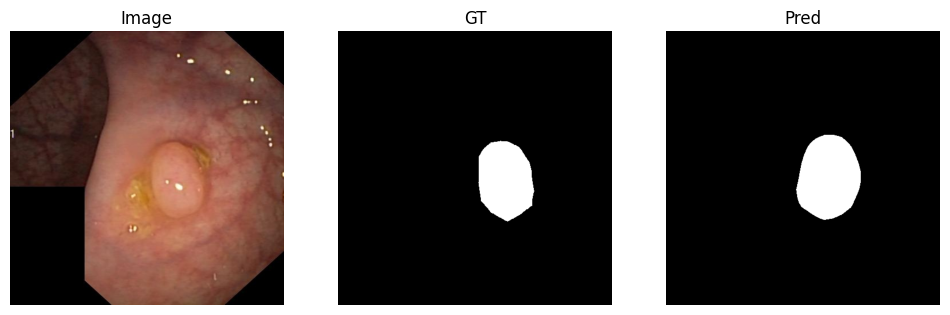

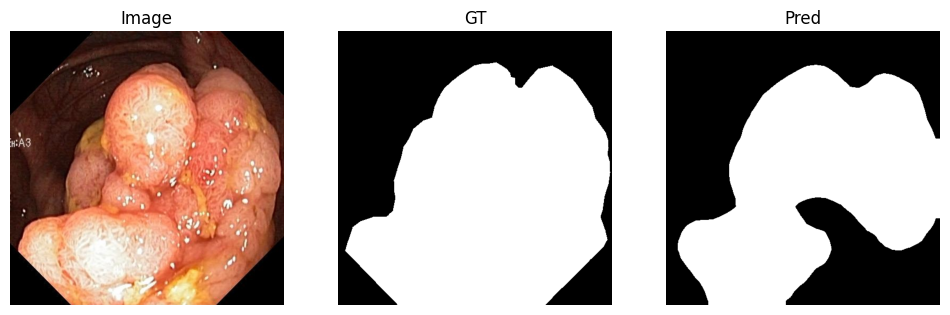

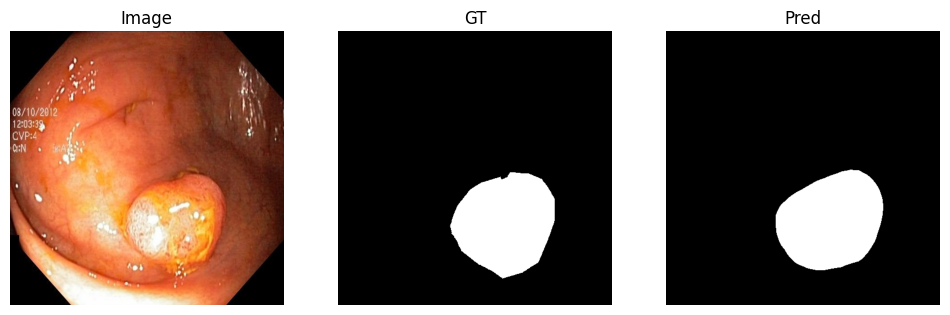

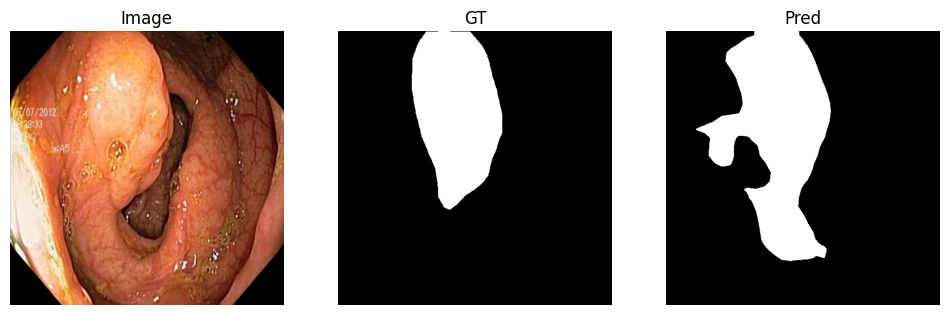

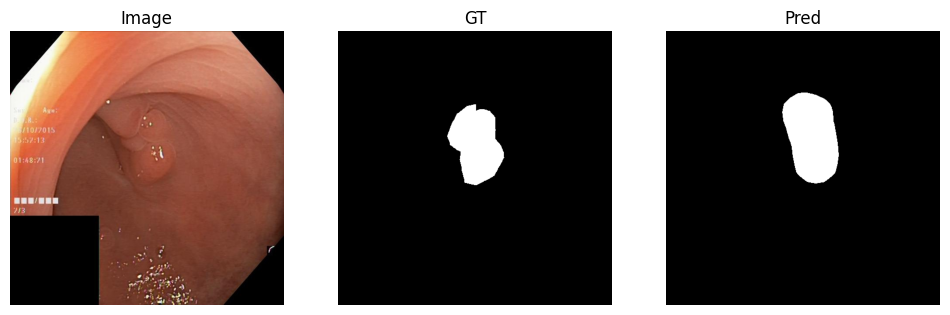

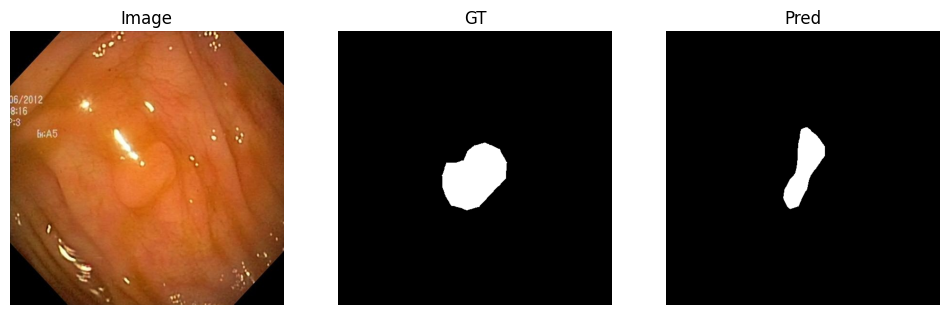

In [ ]:
# CELL 10 - evaluate on test and show samples
import matplotlib.pyplot as plt, numpy as np
# load best
model.load_state_dict(torch.load("/kaggle/working/best_seg_model.pth", map_location=device))
model.eval()

all_dices = []
all_ious = []
with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        masks = batch["mask"].to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        # per-batch metrics
        dice = dice_prob(probs, masks).cpu().item()
        inter = (preds * masks).sum(dim=(1,2,3))
        union = (preds + masks - preds*masks).sum(dim=(1,2,3))
        iou = (inter/(union+1e-7)).mean().cpu().item()
        all_dices.append(dice)
        all_ious.append(iou)

print("Test mean Dice:", sum(all_dices)/len(all_dices), "Test mean IoU:", sum(all_ious)/len(all_ious))

# show 6 examples
n_show = 6
for i in range(n_show):
    sample = test_ds[i]
    img = sample["image"].unsqueeze(0).to(device)
    mask = sample["mask"].numpy().squeeze()
    with torch.no_grad():
        pred = torch.sigmoid(model(img)).squeeze().cpu().numpy()
    pred_bin = (pred > 0.5).astype(int)
    img_np = (img[0].permute(1,2,0).cpu().numpy()*255).astype('uint8')
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Image"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("GT"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_bin, cmap='gray'); plt.title("Pred"); plt.axis('off')
    plt.show()


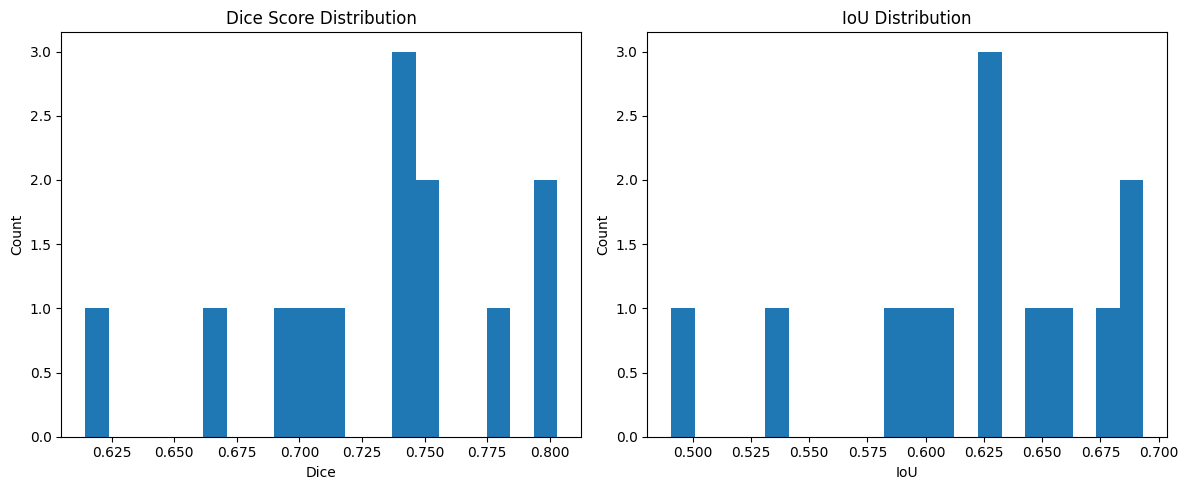

In [ ]:
# CELL 11 - Plot Dice & IoU distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(all_dices, bins=20)
plt.title("Dice Score Distribution")
plt.xlabel("Dice")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(all_ious, bins=20)
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


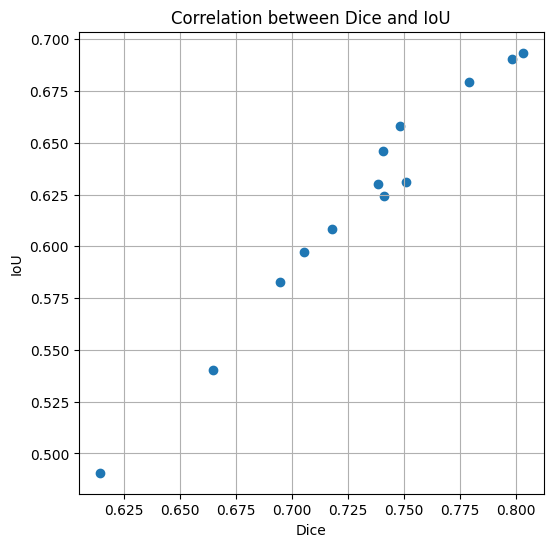

In [ ]:
# CELL 12 - Dice vs IoU scatter plot

plt.figure(figsize=(6,6))
plt.scatter(all_dices, all_ious)
plt.xlabel("Dice")
plt.ylabel("IoU")
plt.title("Correlation between Dice and IoU")
plt.grid(True)
plt.show()


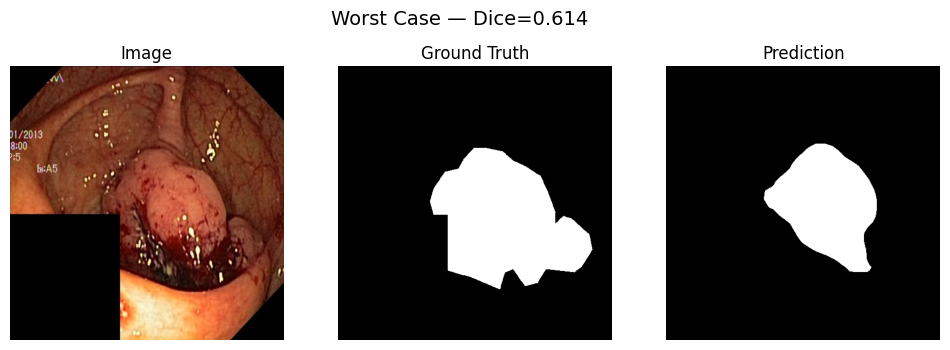

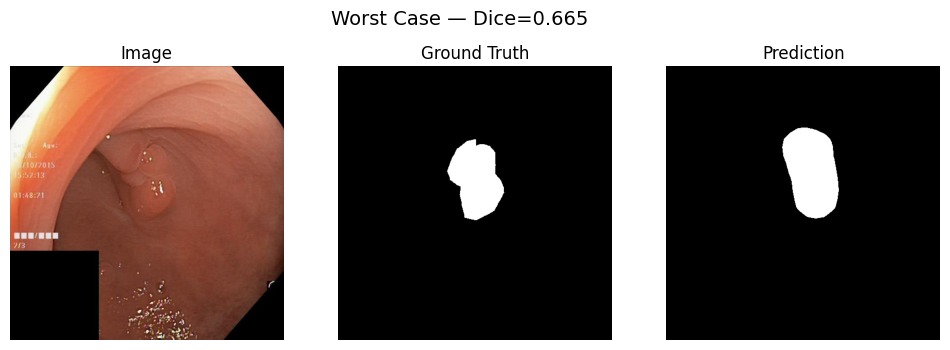

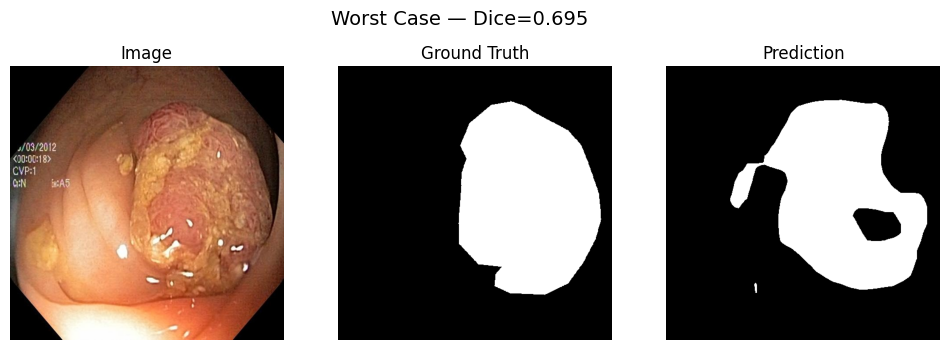

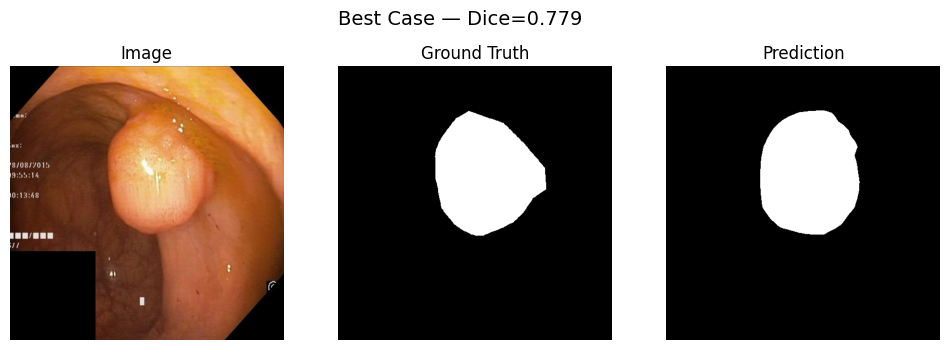

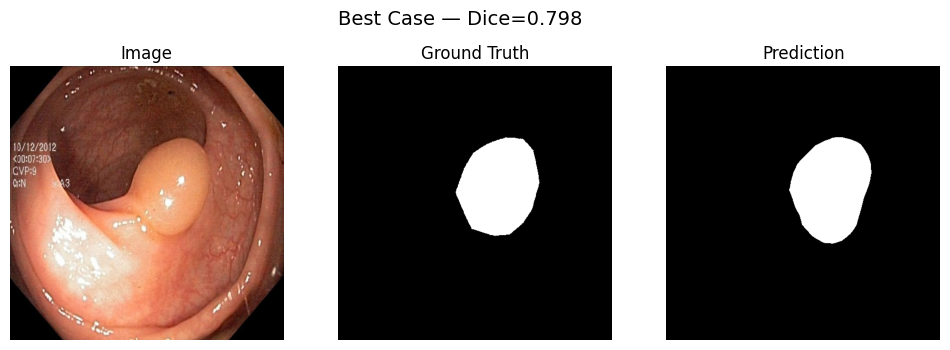

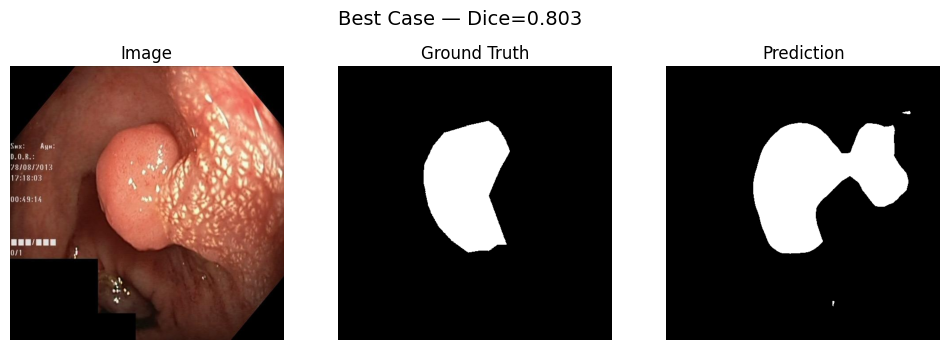

In [ ]:
# CELL 13 - Show best and worst predictions
import numpy as np

# sort indices by dice score
idx_sorted = np.argsort(all_dices)
worst_idx = idx_sorted[:3]
best_idx  = idx_sorted[-3:]

def show_case(test_dataset, model, idx, title=""):
    sample = test_dataset[idx]
    img = sample["image"].unsqueeze(0).to(device)
    gt_mask = sample["mask"].numpy().squeeze()

    with torch.no_grad():
        pred = torch.sigmoid(model(img)).squeeze().cpu().numpy()
    pred_bin = (pred > 0.5).astype(int)

    img_np = (img[0].permute(1,2,0).cpu().numpy() * 255).astype("uint8")

    plt.figure(figsize=(12,4))
    plt.suptitle(title, fontsize=14)

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_bin, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# display
for idx in worst_idx:
    show_case(test_ds, model, idx, title=f"Worst Case — Dice={all_dices[idx]:.3f}")

for idx in best_idx:
    show_case(test_ds, model, idx, title=f"Best Case — Dice={all_dices[idx]:.3f}")
